Exercise: *Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets.*

In [1]:
import tensorflow as tf
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

The dataset is not available in TFDS yet, the [pull request](https://github.com/tensorflow/datasets/pull/361) is still in progress. Lucky for us, the dataset is available in TFRecords, so we will download it. It would take a while, since the dataset is about 1 GB large, with 3,450,000 training sketches and 345,000 test sketches.

In [2]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(
    filename, tf_download_root + filename, cache_dir=".", extract=True
)

1065301781/1065301781 [==============================] - 14s 0us/step


In [3]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [4]:
train_files

['datasets/training.tfrecord-00000-of-00010',
 'datasets/training.tfrecord-00001-of-00010',
 'datasets/training.tfrecord-00002-of-00010',
 'datasets/training.tfrecord-00003-of-00010',
 'datasets/training.tfrecord-00004-of-00010',
 'datasets/training.tfrecord-00005-of-00010',
 'datasets/training.tfrecord-00006-of-00010',
 'datasets/training.tfrecord-00007-of-00010',
 'datasets/training.tfrecord-00008-of-00010',
 'datasets/training.tfrecord-00009-of-00010']

In [5]:
eval_files

['datasets/eval.tfrecord-00000-of-00010',
 'datasets/eval.tfrecord-00001-of-00010',
 'datasets/eval.tfrecord-00002-of-00010',
 'datasets/eval.tfrecord-00003-of-00010',
 'datasets/eval.tfrecord-00004-of-00010',
 'datasets/eval.tfrecord-00005-of-00010',
 'datasets/eval.tfrecord-00006-of-00010',
 'datasets/eval.tfrecord-00007-of-00010',
 'datasets/eval.tfrecord-00008-of-00010',
 'datasets/eval.tfrecord-00009-of-00010']

In [6]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "eval.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [7]:
assert test_classes == train_classes
class_names = [name.strip().lower() for name in train_classes]

In [8]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [9]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64),
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [10]:
def quickdraw_dataset(
    filepaths,
    batch_size=32,
    shuffle_buffer_size=None,
    n_parse_thread=5,
    n_read_threads=5,
    cache=False,
):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_thread)
    return dataset.prefetch(1)

In [11]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10_000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [12]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches = ", sketches)
    print("lengths = ", lengths)
    print("labels = ", labels)

sketches =  tf.Tensor(
[[[ 0.41568628 -0.07291667  0.        ]
  [ 0.30980393 -0.10416666  0.        ]
  [ 0.14117646 -0.02604167  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.31764704  0.0375      0.        ]
  [-0.39607844  0.075       0.        ]
  [-0.21176472 -0.00624999  1.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.06274509  0.18357489  0.        ]
  [-0.04705882  0.25120774  0.        ]
  [-0.01568627  0.31400967  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.03543307  0.0822511   0.        ]
  [ 0.          0.17748916  0.        ]
  [ 0.05511811  0.10389608  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.   

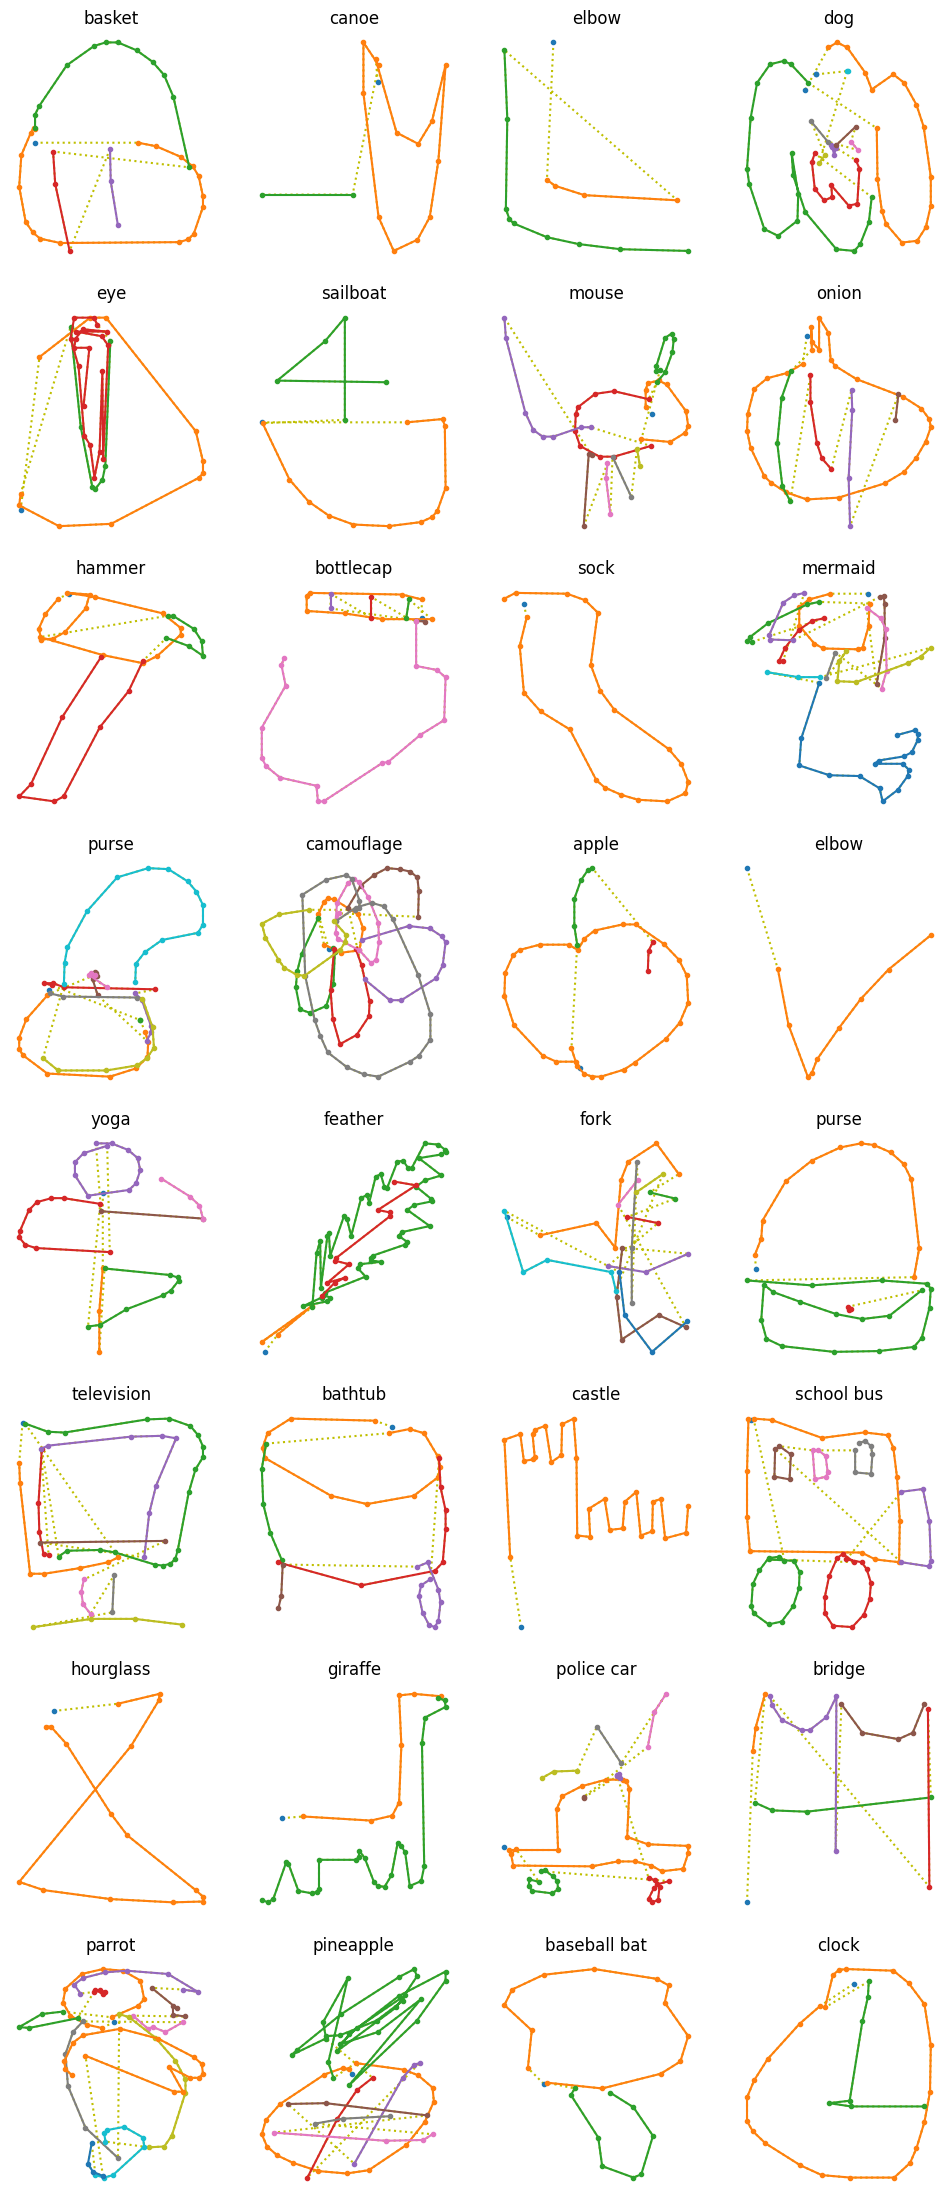

In [13]:
# Each line of the same color is a stroke, whether a point is a stroke's end is indicated by the third number, it is the end if 1.0, else not.
def draw_sketch(sketch, label=None):
    origin = np.array([[1.0, 1.0, 1.0]])
    sketch = np.r_[origin, sketch]
    # The [:,0] convert the array from 1 column matrix to a 1D array
    stroke_end_indices = np.argwhere(sketch[:, -1] == 1.0)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")


def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(
        range(n_sketches), sketches, lengths, labels
    ):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)


for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points.

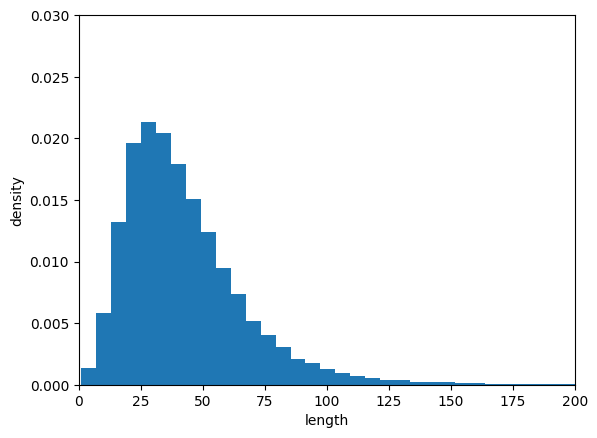

In [14]:
lengths = np.concatenate([length for _, length, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [15]:
def crop_long_sketches(datasets, max_length=100):
    return datasets.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))


cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [16]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(len(class_names), activation="softmax"),
    ]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.0)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy", "sparse_top_k_categorical_accuracy"],
)
history = model.fit(cropped_train_set, epochs=2, validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 1261s 12ms/step - loss: 4.0729 - accuracy: 0.1713 - sparse_top_k_categorical_accuracy: 0.3765 - val_loss: 3.1085 - val_accuracy: 0.3025 - val_sparse_top_k_categorical_accuracy: 0.5897
Epoch 2/2
107813/107813 [==============================] - 1224s 11ms/step - loss: 2.6874 - accuracy: 0.3825 - sparse_top_k_categorical_accuracy: 0.6718 - val_loss: 2.4547 - val_accuracy: 0.4245 - val_sparse_top_k_categorical_accuracy: 0.7149


In [27]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_proba=model.predict(test_set)

5392/5392 [==============================] - 36s 7ms/step


In [29]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_proba))

0.60300934

1/1 [==============================] - 1s 1s/step


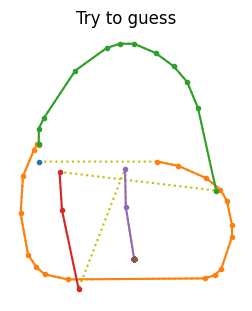

Top-5 predictions
  1. basket: 48.019%
  2. purse: 28.489%
  3. flying saucer: 4.889%
  4. couch: 3.745%
  5. hat: 3.292%
Answer: basket


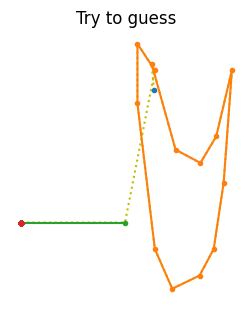

Top-5 predictions
  1. hockey stick: 14.165%
  2. moustache: 9.117%
  3. trumpet: 7.136%
  4. golf club: 6.122%
  5. clarinet: 6.084%
Answer: canoe


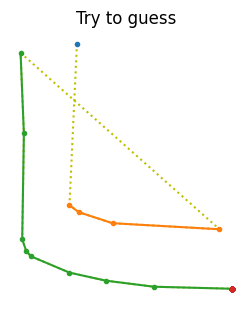

Top-5 predictions
  1. tent: 12.357%
  2. leg: 9.852%
  3. elbow: 7.174%
  4. snowflake: 6.757%
  5. triangle: 3.776%
Answer: elbow


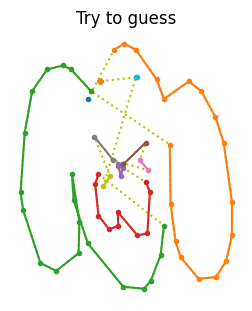

Top-5 predictions
  1. dog: 19.695%
  2. elephant: 16.804%
  3. squirrel: 7.368%
  4. rhinoceros: 5.665%
  5. bat: 4.869%
Answer: dog


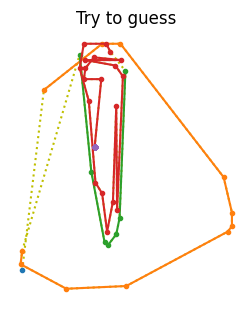

Top-5 predictions
  1. fireplace: 18.478%
  2. microwave: 12.359%
  3. passport: 6.654%
  4. eraser: 5.453%
  5. hospital: 3.970%
Answer: eye


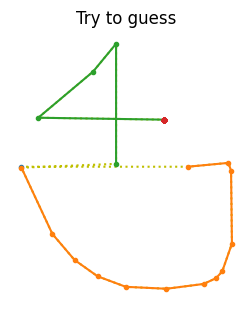

Top-5 predictions
  1. sailboat: 40.580%
  2. cruise ship: 11.621%
  3. screwdriver: 9.043%
  4. aircraft carrier: 6.636%
  5. lipstick: 5.146%
Answer: sailboat


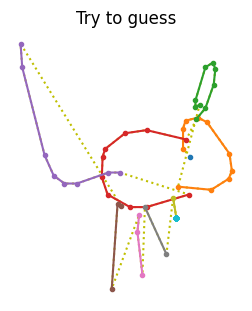

Top-5 predictions
  1. mosquito: 27.826%
  2. ant: 8.926%
  3. bird: 5.792%
  4. scorpion: 4.663%
  5. rhinoceros: 3.281%
Answer: mouse


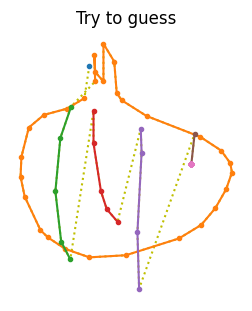

Top-5 predictions
  1. onion: 92.760%
  2. cello: 1.001%
  3. basketball: 0.916%
  4. tiger: 0.500%
  5. steak: 0.492%
Answer: onion


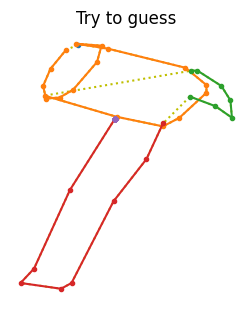

Top-5 predictions
  1. hammer: 23.414%
  2. nail: 9.702%
  3. palm tree: 8.771%
  4. windmill: 7.405%
  5. axe: 6.663%
Answer: hammer


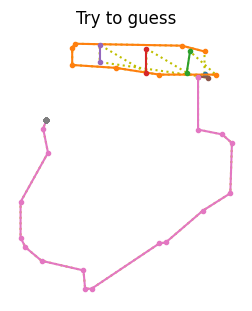

Top-5 predictions
  1. wine bottle: 31.693%
  2. vase: 23.906%
  3. bottlecap: 12.977%
  4. octagon: 7.420%
  5. hexagon: 3.852%
Answer: bottlecap


In [32]:
n_new=  10
y_proba=model.predict(sketches)
top_k = tf.nn.top_k(y_proba, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print('Top-5 predictions')
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100* top_k.values[index, k]
        print('  {}. {}: {:.3f}%'.format(k+1, class_name, proba))
    print('Answer: {}'.format(class_names[labels[index].numpy()]))

In [21]:
model.save('my_sketch_rnn', save_format='tf')